In [1]:
from msmbuilder.example_datasets import AlanineDipeptide
from msmbuilder.preprocessing import MinMaxScaler
%matplotlib inline
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np


import keras
import keras.backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, ZeroPadding3D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, UpSampling3D, Conv3D, UpSampling1D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam




from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


from utils import *



/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead

The dataset consists of ten 10ns trajectories of of alanine dipeptide,
simulated using OpenMM 6.0.1 (CUDA platform, NVIDIA GTX660) with the
AMBER99SB-ILDN force field at 300K (langevin dynamics, friction coefficient
of 91/ps, timestep of 2fs) with GBSA implicit solvent. The coordinates are
saved every 1ps. Each trajectory contains 9,999 snapshots.

In [2]:
trjs = AlanineDipeptide().get().trajectories

alanine_dipeptide already is cached


In [3]:
frame00 = trjs[0][0]

trjs = [t.superpose(frame00) for t in trjs]


In [4]:
trj_xyz = [t.xyz for t in trjs]

In [5]:
sc = MinMaxScaler(feature_range=(-1 , 1))

In [6]:
frames = []
for t in trjs:
    for f in t:
        frames.append(f.xyz.reshape(22, 3))

In [7]:
frames[0].shape

(22, 3)

In [8]:
f_txx_sc = sc.fit_transform(frames)


In [9]:
len(f_txx_sc)

99999

In [10]:
f_txx_sc[0].shape

(22, 3)

In [11]:
data = np.dstack(f_txx_sc)

In [12]:

data = data.reshape((-1, 22, 3))

In [13]:
train, test = train_test_split(data)

In [14]:

data.shape

(99999, 22, 3)

In [15]:
train.shape

(74999, 22, 3)

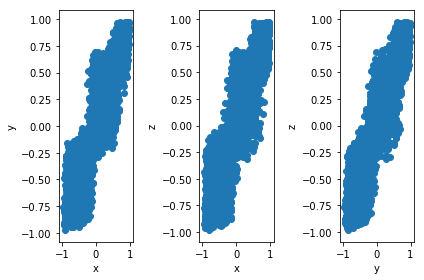

In [16]:
f, (ax1, ax2, ax3) =plt.subplots(1, 3)
ax1.scatter(train[::100, :, 0], train[::100, :, 1])
ax2.scatter(train[::100, :, 0], train[::100, :, 2])
ax3.scatter(train[::100, :, 1], train[::100, :, 2])
ax1.set(xlabel='x', ylabel='y')
ax2.set(xlabel='x', ylabel='z')
ax3.set(xlabel='y', ylabel='z')
f.tight_layout()

# generator

In [17]:
g = Sequential([
    Dense(22 * 3 * 100, input_dim=100),
    LeakyReLU(),
    Reshape((22, 3, 100)),
    Conv2DTranspose(1, (22, 3), activation='tanh', padding='same')
])



g.compile(Adam(), loss='binary_crossentropy')
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6600)              666600    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6600)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 22, 3, 100)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 22, 3, 1)          6601      
Total params: 673,201
Trainable params: 673,201
Non-trainable params: 0
_________________________________________________________________


In [18]:
g.predict_on_batch(make_latent_samples(5, 100)).shape

(5, 22, 3, 1)

# discriminator

In [19]:
d = Sequential([
    
    Conv2D(32, 3, padding='same', strides=2, input_shape=(22, 3, 1)),
    LeakyReLU(),
    Dropout(0.3),
    
    Conv2D(64, 3, padding='same', strides=1),
    LeakyReLU(),
    Dropout(0.3),
    
    
    Conv2D(128, 3, padding='same', strides=1),
    LeakyReLU(),
    Dropout(0.3),
    
    Flatten(),
    Dense(1, activation='sigmoid')
    
], name='disc')
d.compile(Adam(), 'binary_crossentropy')
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 11, 2, 32)         320       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 11, 2, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 2, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 2, 64)         18496     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 11, 2, 64)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 11, 2, 64)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 2, 128)        73856     
__________

# GAN

In [20]:
gan = Sequential([g, d])
gan.compile(Adam(), 'binary_crossentropy')

In [21]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 22, 3, 1)          673201    
_________________________________________________________________
disc (Sequential)            (None, 1)                 95489     
Total params: 768,690
Trainable params: 768,690
Non-trainable params: 0
_________________________________________________________________


# Train Loop

In [22]:
batch_size = 250
num_epochs = 25
eval_size = 200
losses = []

for epoch in range(num_epochs):
    for i in range(len(train)//batch_size):
        # ------------------
        # Train Disciminator
        # ------------------
        make_trainable(d, True)

        confs = train[i*batch_size:(i+1)*batch_size]  # real conformations from training set
        confs = confs.reshape(-1, 22, 3, 1)
    
        # Sample 100 dimensional noise and generate fake confs
        noise = make_latent_samples(batch_size, 100)
        fake_confs = g.predict_on_batch(noise)
        
        d.train_on_batch(confs, np.ones((batch_size, 1)) - 0.1)  # make real label 0.9 instead of 1
        d.train_on_batch(fake_confs, np.zeros((batch_size, 1)))    
    
        # ---------------------
        #  Train Generator via GAN (swith off discriminator)
        # ---------------------
        noise = make_latent_samples(batch_size, 100)  # generate new noise
        make_trainable(d, False)
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)) - 0.1)
        
    # Evaluate performance after epoch
    conf_eval_real = test[np.random.choice(len(test), eval_size, replace=False)]
    conf_eval_real = conf_eval_real.reshape(-1, 22, 3, 1)
    noise = make_latent_samples(eval_size, 100)
    conf_eval_fake = g.predict_on_batch(noise)
    
    d_loss_r = d.test_on_batch(conf_eval_real, np.ones(shape=(eval_size, 1)))
    d_loss_f = d.test_on_batch(conf_eval_fake, np.zeros(shape=(eval_size, 1)))
    d_loss = (d_loss_r + d_loss_f) / 2
    
    g_loss = gan.test_on_batch(noise, np.ones(shape=(eval_size, 1)))  # we want the fake to be realistic!
        
    print("Epoch: {:>3}/{} Discriminator Loss: {:>6.4f} Generator Loss: {:>6.4f}".format(epoch+1, num_epochs, d_loss, g_loss))
    
    losses.append((d_loss, g_loss))
    

/Users/je714/miniconda3/envs/dl/lib/python3.6/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch:   1/25 Discriminator Loss: 0.8681 Generator Loss: 0.2859
Epoch:   2/25 Discriminator Loss: 0.7257 Generator Loss: 0.3753
Epoch:   3/25 Discriminator Loss: 0.8266 Generator Loss: 0.2819
Epoch:   4/25 Discriminator Loss: 0.6792 Generator Loss: 0.4201
Epoch:   5/25 Discriminator Loss: 0.8956 Generator Loss: 0.2431
Epoch:   6/25 Discriminator Loss: 0.8399 Generator Loss: 0.2826
Epoch:   7/25 Discriminator Loss: 0.8314 Generator Loss: 0.2852
Epoch:   8/25 Discriminator Loss: 0.6738 Generator Loss: 0.4350
Epoch:   9/25 Discriminator Loss: 0.6727 Generator Loss: 0.4679
Epoch:  10/25 Discriminator Loss: 0.8719 Generator Loss: 0.2680
Epoch:  11/25 Discriminator Loss: 0.9698 Generator Loss: 0.2341
Epoch:  12/25 Discriminator Loss: 0.9931 Generator Loss: 0.2397
Epoch:  13/25 Discriminator Loss: 0.9195 Generator Loss: 0.2236
Epoch:  14/25 Discriminator Loss: 1.0326 Generator Loss: 0.1677
Epoch:  15/25 Discriminator Loss: 1.0659 Generator Loss: 0.1540
Epoch:  16/25 Discriminator Loss: 1.2281

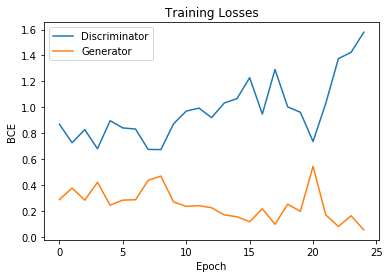

In [23]:
losses = np.array(losses)

fig, ax = plt.subplots()
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()
ax.set(ylabel='BCE', xlabel='Epoch')
plt.show()


In [24]:
f0 = g.predict(make_latent_samples(100, 100))

In [25]:

f0[:,:,:,0].shape

(100, 22, 3)

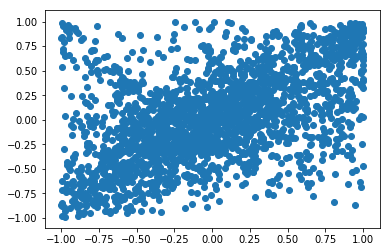

In [26]:
plt.scatter(f0[:,:,0,0], f0[:,:,1,0])

In [27]:
import mdtraj

In [28]:
ala_top = trjs[0].topology

In [29]:
fk_tr = f0[:,:,:,0]

In [30]:
fake_traj_orig_space = [sc.inverse_transform(t) for t in fk_tr]

In [31]:
txx_fake = np.dstack(fake_traj_orig_space).reshape(100, 22, 3)

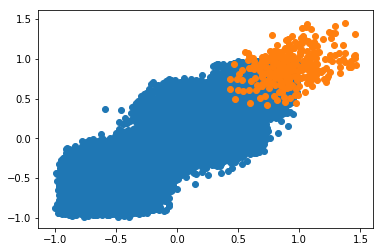

In [32]:
scatter(train)
plt.scatter(txx_fake[:, 0], txx_fake[:, 1])

In [33]:
ala_top

<mdtraj.Topology with 1 chains, 3 residues, 22 atoms, 21 bonds at 0x12e678f98>

In [34]:
fake_traj = mdtraj.Trajectory(fake_traj_orig_space, topology=ala_top)
c = fake_traj.center_coordinates()
c.superpose(c, 0)

<mdtraj.Trajectory with 100 frames, 22 atoms, 3 residues, without unitcells at 0x13883e5c0>

In [35]:
c.save_netcdf('fake_traj.nc')

In [36]:

f0[0].shape

(22, 3, 1)

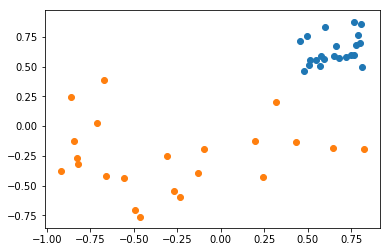

In [37]:
ax = scatter(test[0])
scatter(f0[0,:,:,0], ax=ax)

In [38]:
f0[0].shape

(22, 3, 1)

In [39]:
real_traj = trjs[0]

In [40]:
real_traj.center_coordinates()
real_traj.superpose(real_traj, 0)
real_traj.save_netcdf('real_traj.nc')